# Importing Libraries

In [1]:
from scipy.io import loadmat, savemat

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import random
import seaborn as sns

from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap 
from sklearn.decomposition import KernelPCA
from sklearn.manifold import LocallyLinearEmbedding
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler

import os
print(os.environ['CONDA_DEFAULT_ENV'])

c:\Users\Dell\anaconda3\envs\dslab\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


dslab


# Loading Data

Select the dataset you want to work with by setting the variable 'dataset_name'

In [2]:
def read_HSI(dataset):
    if dataset == 'Salinas':
        data = loadmat('../Datasets/Salinas/Salinas_corrected.mat')['salinas_corrected']
        gt = loadmat('../Datasets/Salinas/Salinas_gt.mat')['salinas_gt']
        print(f"data shape: {data.shape}\ngt shape: {gt.shape}")
        return data, gt
    elif dataset == 'IndianPines':
        data = loadmat('../Datasets/IndianPines/Indian_pines_corrected.mat')['indian_pines_corrected']
        gt = loadmat('../Datasets/IndianPines/Indian_pines_gt.mat')['indian_pines_gt']
        print(f"data shape: {data.shape}\ngt shape: {gt.shape}")
        return data, gt
    
def extract_pixels(X, y):
  q = X.reshape(-1, X.shape[2])
  df = pd.DataFrame(data = q)
  df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
  df.columns= [f'band{i}' for i in range(1, 1+X.shape[2])]+['class']
  # df.to_csv(f'./Datasets/Raw/{dataset_name}/{dataset_name}.csv')
  return df
    
# dataset_name = 'IndianPines'
dataset_name = 'Salinas'
data, gt = read_HSI(dataset=dataset_name)

df = extract_pixels(data, gt)
print(f"df shape: {df.shape}")

if dataset_name == 'Salinas':
    class_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow',
                    'Fallow_rough_plow','Fallow_smooth','Stubble','Celery',
                    'Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green',
                    'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk',
                    'Lettuce_romaine_7wk','Vinyard_untrained','Vinyard_vertical']
elif dataset_name == 'IndianPines':
    class_name = [ "Alfalfa", "Corn-notill", "Corn-mintill","Corn", "Grass-pasture", 
                    "Grass-trees","Grass-pasture-mowed", "Hay-windrowed", "Oats",
                    "Soybean-notill", "Soybean-mintill", "Soybean-clean","Wheat",
                    "Woods", "Buildings-Grass-Trees-Drives","Stone-Steel-Towers"]
    


data shape: (512, 217, 204)
gt shape: (512, 217)
df shape: (111104, 205)


# Visualizing Dataset

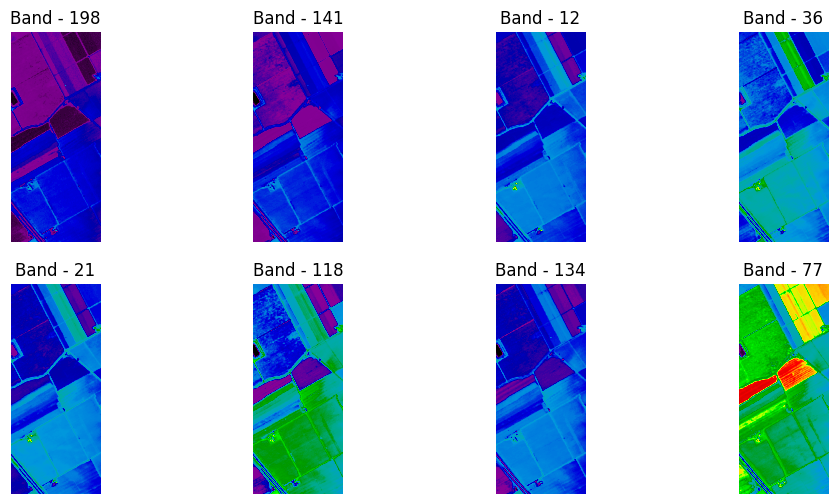

In [3]:
#Spectral bands
fig = plt.figure(figsize = (12, 6))

for i in range(1, 8+1):
    fig.add_subplot(2,4, i)
    q = np.random.randint(data.shape[2])
    plt.imshow(data[:,:,q], cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {q}')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


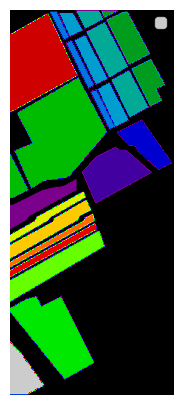

In [4]:
# Ground Truth
plt.figure(figsize=(10, 5))
plt.imshow(gt, cmap='nipy_spectral')
# plt.colorbar
plt.legend()
plt.axis('off')
plt.show()

# Dimensionality Reduction

## Utils

In [5]:
from sklearn.preprocessing import StandardScaler
from pydiffmap import diffusion_map as dm
import numpy as np

def show_random_bands(df_dr):
    fig = plt.figure(figsize = (20, 10))

    random_bands = random.sample(range(1, df_dr.shape[1]), 8)
    for i in range(1, 8+1):
        fig.add_subplot(2,4, i)
        plt.imshow(df_dr.loc[:, f'Band-{random_bands[i-1]}'].values.reshape(y.shape[0], y.shape[1]), cmap='nipy_spectral')
        plt.axis('off')
        plt.title(f'Band - {random_bands[i-1]}')

def normalize_df(df):
    # Separate the features and class columns
    features = df.iloc[:, :-1]
    class_column = df.iloc[:, -1]

    # Normalize the features
    normalized_features = (features - features.min()) / (features.max() - features.min())

    # Concatenate the normalized features with the class column
    return pd.concat([normalized_features, class_column], axis=1)


def split_data(df, n_components):
    # Number of bands (columns in the df, excluding the class)
    num_bands = df.shape[1] - 1  # Exclude the class column

    # Split the HSI data into n_components chunks
    segment_size = num_bands // n_components
    split_list = []

    # Split the data into segments
    for i in range(n_components):
        start_idx = i * segment_size
        end_idx = start_idx + segment_size if i != n_components - 1 else num_bands  # Ensure the last segment gets the remaining bands
        
        # Extract the subset of bands for the current segment
        segment_df = df.iloc[:, start_idx:end_idx]
        split_list.append(segment_df)
        print(f'Split {i+1}')

    # Return the split segments
    return split_list

def standardize_df(df):
    # Separate the features and class columns
    features = df.iloc[:, :-1]
    class_column = df.iloc[:, -1]

    scaler = StandardScaler()
    std_features = scaler.fit_transform(features)

    # Concatenate the normalized features with the class column
    return pd.concat([pd.DataFrame(std_features), class_column], axis=1)

def apply_DR(df, method, n_components):
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1:].values

    if method == 'PCA':
        pca = PCA(n_components = n_components, random_state=0)
        dt = pca.fit_transform(X)
    elif method == 'FastICA':
        fast_ica = FastICA(n_components=n_components, whiten='unit-variance', max_iter=400, random_state=0)
        dt = fast_ica.fit_transform(X)
    elif method == 'UMAP':
        umap_reducer = umap.UMAP(n_components=n_components)
        dt = umap_reducer.fit_transform(X)
    elif method == 'TSNE':
        tsne = TSNE(n_components=n_components, method='exact', learning_rate='auto', init='random', perplexity=3)
        dt = tsne.fit_transform(X)
    elif method == 'KPCA':
        transformer = KernelPCA(n_components=n_components, kernel='cosine')
        dt = transformer.fit_transform(X)
    elif method == 'LLE':
        # Apply LLE
        lle = LocallyLinearEmbedding(n_neighbors=10, n_components=n_components, method='standard')
        dt = lle.fit_transform(X)
    elif method == 'DiffMaps':
        epsilon = 0.7  # Diffusion parameter; adjust based on dataset        # Apply Diffusion Maps
        mydmap = dm.DiffusionMap.from_sklearn(n_evecs=n_components, epsilon=epsilon)
        dt = mydmap.fit_transform(X)
    elif method == 'Corr':
        corr = df.iloc[:, :-1].corr()
        # print(corr)
        abs_corr = corr.map(lambda x: abs(x))
        # print(abs_corr)
        # Create an array to track which columns to keep
        columns = np.full((abs_corr.shape[0],), True, dtype=bool)
        # Calculate the average correlation for each feature
        average_correlations = abs_corr.mean().values
        # Get the indices of the top n_components features based on average correlation
        top_indices = np.argsort(average_correlations)[-n_components:]

        # Set the columns to keep based on the top indices
        for idx in range(abs_corr.shape[0]):
            if idx not in top_indices:
                columns[idx] = False

        # Filter the DataFrame to keep only the selected features
        dt = df.iloc[:, :-1].iloc[:, columns]

        # # Display the selected features
        # print("Selected features:\n", df_selected.columns)
        # print("Filtered DataFrame:\n", df_selected.head())
    elif method == 'SOM':
        feature_names = df.columns[:-1]


        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)  # Scale features to range [0, 1]

        # Set up the SOM parameters
        som_x, som_y = 5, 5  # grid width and height
        input_len = X.shape[1]  # Number of features in the dataset

        # Initialize and train the SOM
        som = MiniSom(som_x, som_y, input_len, sigma=1.0, learning_rate=0.5)
        som.random_weights_init(X)
        som.train_random(X, 1000)  # Train for 1000 iterations

        # Extract the SOM weights (prototypes)
        weights = som.get_weights()

        # Calculate the feature importance based on weights
        # We will take the average of weights across all SOM nodes for each feature
        average_weights = np.mean(weights, axis=(0, 1))

        # Select features with the highest average weight values
        # You can adjust the number of features to select based on your needs
        selected_indices = np.argsort(average_weights)[-n_components:]
        selected_indices = np.sort(selected_indices)

        #important for RNNs: keep order of bands. 
        print(selected_indices)
        selected_features = [feature_names[i] for i in selected_indices]

        # Create the reduced dataframe with selected features
        X_reduced = X[:, selected_indices]
        dt = pd.DataFrame(X_reduced, columns=selected_features)

    elif method == 'Var':
  
        feature_names = df.columns[:-1]

        # Step 1: Compute the variance of each band (column)
        variances = np.var(X, axis=0)
        
        # Step 2: Sort the bands by variance in descending order
        sorted_indices = np.argsort(variances)[::-1]  # indices of bands sorted by variance
        
        # Step 3: Select the top k bands (e.g., k=3)
        top_k_indices = sorted_indices[:n_components]
        top_k_indices = np.sort(top_k_indices)
        selected_features = [feature_names[i] for i in top_k_indices]

        
        # Step 4: Select the corresponding bands from the original data
        X_selected = X[:, top_k_indices]
        dt = pd.DataFrame(X_selected, columns=selected_features)


        
    dr_df = pd.concat([pd.DataFrame(data = dt), pd.DataFrame(data = y.ravel())], axis = 1)
    dr_df.columns = [f'Band-{i}' for i in range(1,n_components+1)]+['class']

    return dr_df

def save_data(method, dr_df, X, n_components):
    # saving to .mat
    reshaped_data = np.array([row[1][:-1] for row in dr_df.iterrows()]).reshape((X.shape[0], X.shape[1], n_components))
    print(f'../Datasets/{dataset_name}/{dataset_name}_{method}_{n_components}.mat')
    savemat(f'../Datasets/{dataset_name}/{dataset_name}_{method}_{n_components}.mat', {'data': reshaped_data})

In [6]:
n_components = 8

## PCA (OK)

In [20]:
method='PCA'
dr_df = apply_DR(df, method=method, n_components=n_components)
dr_df_norm = normalize_df(dr_df)
# show_random_bands(dr_df_norm)
save_data(method, dr_df_norm, data, n_components)
dr_df_norm.head()

../Datasets/IndianPines/IndianPines_PCA_8.mat


,Band-1,Band-2,Band-3,Band-4,Band-5,Band-6,Band-7,Band-8,class
0,0.662233,0.532763,0.247282,0.365744,0.237597,0.473925,0.506973,0.353934,3
1,0.685865,0.432482,0.276967,0.207633,0.351875,0.391381,0.523213,0.600233,3
2,0.693712,0.401739,0.291990,0.146530,0.373770,0.450315,0.516029,0.584449,3
3,0.685253,0.422514,0.277624,0.214430,0.351575,0.384493,0.534734,0.597576,3
4,0.662478,0.500571,0.237042,0.322566,0.250750,0.335023,0.594988,0.335331,3


## Splitted PCA


In [ ]:
n_components = 8
split_segments = split_data(df, n_components)

# DataFrame to hold the reduced components
dr_df = pd.DataFrame()


segment_idx = 1
# Apply PCA (or any DR method) to each split segment and concatenate results
for segment in split_segments:
    print(f'Reducing split {segment_idx}')
    segment_idx += 1
    
    # Apply PCA to each segment (n_components=1 for each segment)
    dr_df_segment = apply_DR(segment, method='PCA', n_components=1)  
    # Concatenate the reduced components directly (no exclusion)
    dr_df = pd.concat([dr_df, dr_df_segment.iloc[:, :-1]], axis=1)  # Concatenate without excluding columns

# Add the class column from the original dataframe (assumes class column is the last column)
dr_df['class'] = df['class']

# Now dr_df contains the reduced data from all segments with the class column
# Normalize the data if needed
dr_df_norm = normalize_df(dr_df)

# Save the reduced and normalized data
save_data('PCA-Split', dr_df_norm, data, n_components)

# Show the first few rows of the reduced and normalized data
dr_df_norm.head()


Split 1
Split 2
Split 3
Split 4
Split 5
Split 6
Split 7
Split 8
Reducing split 1
Reducing split 2
Reducing split 3
Reducing split 4
Reducing split 5
Reducing split 6
Reducing split 7
Reducing split 8
../Datasets/IndianPines/IndianPines_PCA-Split_8.mat


,Band-1,Band-1,Band-1,Band-1,Band-1,Band-1,Band-1,Band-1,class
0,0.370692,0.186657,0.564299,0.459695,0.555576,0.498379,0.463612,0.400987,3
1,0.454621,0.193689,0.483520,0.515203,0.609231,0.543347,0.502632,0.433469,3
2,0.480281,0.195063,0.460145,0.536582,0.630946,0.563985,0.520756,0.452017,3
3,0.461887,0.201944,0.475737,0.524142,0.619138,0.554099,0.510214,0.438798,3
4,0.390548,0.200843,0.533508,0.484519,0.581356,0.521238,0.476945,0.413910,3


## FastICA (OK)

In [9]:
method='FastICA'
dr_df = apply_DR(df, method=method, n_components=n_components)
dr_df_norm = normalize_df(dr_df)
# show_random_bands(dr_df_norm)
save_data(method, dr_df_norm, data, n_components)
dr_df_norm.head()

c:\Users\Dell\anaconda3\envs\dslab\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


../Datasets/IndianPines/IndianPines_FastICA_8.mat


,Band-1,Band-2,Band-3,Band-4,Band-5,Band-6,Band-7,Band-8,class
0,0.318170,0.376813,0.499140,0.823806,0.491274,0.261989,0.340390,0.431296,3
1,0.630057,0.314440,0.507648,0.803284,0.477844,0.215034,0.318453,0.582820,3
2,0.671748,0.278648,0.505296,0.791113,0.476943,0.155516,0.404325,0.599329,3
3,0.617851,0.323807,0.514096,0.802806,0.480870,0.213555,0.319382,0.595210,3
4,0.237237,0.331653,0.513472,0.835176,0.519551,0.255475,0.265605,0.528882,3


## Splited ICA

In [42]:
n_components = 30
split_segments = split_data(df, n_components)

# DataFrame to hold the reduced components
dr_df = pd.DataFrame()


segment_idx = 1
# Apply FastICA (or any DR method) to each split segment and concatenate results
for segment in split_segments:
    print(f'Reducing split {segment_idx}')
    segment_idx += 1
    
    # Apply FastICA to each segment (n_components=1 for each segment)
    dr_df_segment = apply_DR(segment, method='FastICA', n_components=1)  
    # Concatenate the reduced components directly (no exclusion)
    dr_df = pd.concat([dr_df, dr_df_segment.iloc[:, :-1]], axis=1)  # Concatenate without excluding columns

# Add the class column from the original dataframe (assumes class column is the last column)
dr_df['class'] = df['class']

# Now dr_df contains the reduced data from all segments with the class column
# Normalize the data if needed
dr_df_norm = normalize_df(dr_df)

# Save the reduced and normalized data
save_data('FastICA-Split', dr_df_norm, data, n_components)

# Show the first few rows of the reduced and normalized data
dr_df_norm.head()


Split 1
Split 2
Split 3
Split 4
Split 5
Split 6
Split 7
Split 8
Split 9
Split 10
Split 11
Split 12
Split 13
Split 14
Split 15
Split 16
Split 17
Split 18
Split 19
Split 20
Split 21
Split 22
Split 23
Split 24
Split 25
Split 26
Split 27
Split 28
Split 29
Split 30
Reducing split 1
Reducing split 2
Reducing split 3
Reducing split 4
Reducing split 5
Reducing split 6
Reducing split 7
Reducing split 8
Reducing split 9
Reducing split 10
Reducing split 11
Reducing split 12
Reducing split 13
Reducing split 14
Reducing split 15
Reducing split 16
Reducing split 17
Reducing split 18
Reducing split 19
Reducing split 20
Reducing split 21
Reducing split 22
Reducing split 23
Reducing split 24
Reducing split 25
Reducing split 26
Reducing split 27
Reducing split 28
Reducing split 29
Reducing split 30
../Datasets/Salinas/Salinas_FastICA-Split_30.mat


,Band-1,Band-1,Band-1,Band-1,Band-1,Band-1,Band-1,Band-1,Band-1,Band-1,...,Band-1,Band-1,Band-1,Band-1,Band-1,Band-1,Band-1,Band-1,Band-1,class
0,0.253511,0.200758,0.182034,0.193188,0.196324,0.197185,0.749349,0.772530,0.762251,0.749833,...,0.279484,0.172916,0.140675,0.063878,0.144349,0.250583,0.258995,0.254204,0.226848,0
1,0.250460,0.200758,0.180913,0.192314,0.198149,0.200566,0.751958,0.775098,0.763344,0.750282,...,0.282627,0.174886,0.141997,0.065857,0.148640,0.254699,0.261346,0.256022,0.228127,0
2,0.250137,0.196413,0.178234,0.186675,0.192934,0.194274,0.759487,0.781368,0.769202,0.756951,...,0.275361,0.170569,0.139246,0.064522,0.142893,0.247715,0.255005,0.247617,0.221801,0
3,0.249978,0.192854,0.172441,0.181607,0.185658,0.186798,0.768272,0.788764,0.777356,0.765794,...,0.266425,0.164860,0.134343,0.061594,0.136738,0.236496,0.243289,0.240677,0.213105,0
4,0.245195,0.191636,0.168815,0.178447,0.182598,0.182384,0.774960,0.796570,0.785372,0.774039,...,0.262392,0.162459,0.132035,0.061478,0.132826,0.230721,0.240679,0.234729,0.208682,0


## UMAP (OK)

In [10]:
method='UMAP'
dr_df = apply_DR(df, method=method, n_components=n_components)
dr_df_norm = normalize_df(dr_df)
# show_random_bands(dr_df_norm)
save_data(method, dr_df_norm, data, n_components)
dr_df_norm.head()

../Datasets/IndianPines/IndianPines_UMAP_8.mat


,Band-1,Band-2,Band-3,Band-4,Band-5,Band-6,Band-7,Band-8,class
0,0.856573,0.261881,0.864347,0.460839,0.573100,0.561675,0.888325,0.292971,3
1,0.955616,0.726897,0.531894,0.382027,0.451317,0.497995,0.553983,0.401348,3
2,0.959406,0.755131,0.539100,0.395315,0.435395,0.526018,0.533424,0.411426,3
3,0.958619,0.731619,0.533205,0.380043,0.448090,0.499219,0.548948,0.405112,3
4,0.908522,0.452901,0.821932,0.172737,0.362854,0.582321,0.911058,0.307910,3


## Splited UMAP


In [8]:
n_components = 30
split_segments = split_data(df, n_components)

# DataFrame to hold the reduced components
dr_df = pd.DataFrame()


segment_idx = 1
# Apply UMAP (or any DR method) to each split segment and concatenate results
for segment in split_segments:
    print(f'Reducing split {segment_idx} - shape: {segment.shape}')
    segment_idx += 1
    
    # Apply UMAP to each segment (n_components=1 for each segment)
    dr_df_segment = apply_DR(segment, method='UMAP', n_components=1)  
    # Concatenate the reduced components directly (no exclusion)
    dr_df = pd.concat([dr_df, dr_df_segment.iloc[:, :-1]], axis=1)  # Concatenate without excluding columns

# Add the class column from the original dataframe (assumes class column is the last column)
dr_df['class'] = df['class']

# Now dr_df contains the reduced data from all segments with the class column
# Normalize the data if needed
dr_df_norm = normalize_df(dr_df)

# Save the reduced and normalized data
save_data('UMAP-Split', dr_df_norm, data, n_components)

# Show the first few rows of the reduced and normalized data
dr_df_norm.head()


Split 1
Split 2
Split 3
Split 4
Split 5
Split 6
Split 7
Split 8
Split 9
Split 10
Split 11
Split 12
Split 13
Split 14
Split 15
Split 16
Split 17
Split 18
Split 19
Split 20
Split 21
Split 22
Split 23
Split 24
Split 25
Split 26
Split 27
Split 28
Split 29
Split 30
Reducing split 1 - shape: (111104, 6)


c:\Users\Dell\anaconda3\envs\dslab\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Reducing split 2 - shape: (111104, 6)


c:\Users\Dell\anaconda3\envs\dslab\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Reducing split 3 - shape: (111104, 6)
Reducing split 4 - shape: (111104, 6)
Reducing split 5 - shape: (111104, 6)
Reducing split 6 - shape: (111104, 6)
Reducing split 7 - shape: (111104, 6)
Reducing split 8 - shape: (111104, 6)
Reducing split 9 - shape: (111104, 6)
Reducing split 10 - shape: (111104, 6)
Reducing split 11 - shape: (111104, 6)
Reducing split 12 - shape: (111104, 6)
Reducing split 13 - shape: (111104, 6)
Reducing split 14 - shape: (111104, 6)
Reducing split 15 - shape: (111104, 6)
Reducing split 16 - shape: (111104, 6)
Reducing split 17 - shape: (111104, 6)
Reducing split 18 - shape: (111104, 6)
Reducing split 19 - shape: (111104, 6)


c:\Users\Dell\anaconda3\envs\dslab\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Reducing split 20 - shape: (111104, 6)


c:\Users\Dell\anaconda3\envs\dslab\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Reducing split 21 - shape: (111104, 6)
Reducing split 22 - shape: (111104, 6)
Reducing split 23 - shape: (111104, 6)
Reducing split 24 - shape: (111104, 6)
Reducing split 25 - shape: (111104, 6)
Reducing split 26 - shape: (111104, 6)
Reducing split 27 - shape: (111104, 6)
Reducing split 28 - shape: (111104, 6)
Reducing split 29 - shape: (111104, 6)
Reducing split 30 - shape: (111104, 30)
../Datasets/Salinas/Salinas_UMAP-Split_30.mat


,Band-1,Band-1,Band-1,Band-1,Band-1,Band-1,Band-1,Band-1,Band-1,Band-1,...,Band-1,Band-1,Band-1,Band-1,Band-1,Band-1,Band-1,Band-1,Band-1,class
0,0.605033,0.457307,0.371248,0.623318,0.403638,0.402714,0.953352,0.482790,0.084028,0.109714,...,0.401371,0.390461,0.429208,0.423214,0.467615,0.520817,0.544133,0.424514,0.554987,0
1,0.092186,0.456933,0.365408,0.629744,0.405951,0.405499,0.954817,0.499442,0.104977,0.116022,...,0.407375,0.396704,0.424866,0.423117,0.460149,0.505253,0.543446,0.423922,0.550265,0
2,0.526375,0.518742,0.362353,0.659297,0.389752,0.397491,0.949001,0.051822,0.358421,0.239357,...,0.383513,0.386043,0.424427,0.427133,0.462207,0.537858,0.561968,0.434644,0.573223,0
3,0.393991,0.436542,0.349403,0.699095,0.325298,0.386422,0.915892,0.082171,0.104235,0.389723,...,0.308984,0.372757,0.393274,0.410783,0.441881,0.535412,0.572136,0.426439,0.590779,0
4,0.593671,0.446958,0.340535,0.670249,0.318251,0.369573,0.895435,0.064297,0.125947,0.136667,...,0.294546,0.373902,0.377087,0.410961,0.435048,0.525485,0.574298,0.419196,0.593603,0


## LLE

In [11]:
method='LLE'
dr_df = apply_DR(df, method=method, n_components=n_components)
dr_df_norm = normalize_df(dr_df)
# show_random_bands(dr_df_norm)
save_data(method, dr_df_norm, data, n_components)
dr_df_norm

,Band-1,Band-2,Band-3,Band-4,Band-5,Band-6,Band-7,Band-8,class
0,0.309556,0.417246,0.131868,0.243973,0.724580,0.049815,0.670479,0.337404,3
1,0.297666,0.458359,0.073149,0.222003,0.722256,0.521891,0.628919,0.137858,3
2,0.289824,0.463115,0.042563,0.214613,0.725247,0.662535,0.621144,0.075692,3
3,0.297195,0.459209,0.071507,0.221473,0.722398,0.536481,0.627734,0.132181,3
4,0.309297,0.425655,0.119974,0.238152,0.721299,0.019362,0.672904,0.343286,3
...,...,...,...,...,...,...,...,...,...
21020,0.896828,0.451605,0.243307,0.132555,0.969627,0.449346,0.632401,0.260935,0
21021,0.900187,0.452561,0.237331,0.155678,0.965029,0.448312,0.629961,0.260769,0
21022,0.906662,0.454425,0.225211,0.203125,0.956992,0.446169,0.625429,0.260101,0
21023,0.917454,0.457202,0.210502,0.252426,0.995433,0.438603,0.610217,0.258058,0


## Diffusion Maps (OK)

In [12]:
method='DiffMaps'
dr_df = apply_DR(normalize_df(df), method=method, n_components=n_components)
dr_df_norm = normalize_df(dr_df)
# show_random_bands(dr_df_norm)
save_data(method, dr_df_norm, data, n_components)
dr_df_norm.head()

,Band-1,Band-2,Band-3,Band-4,Band-5,Band-6,Band-7,Band-8,class
0,0.735618,0.144321,0.998278,0.096561,0.309254,0.502205,0.423192,0.212073,3
1,0.797558,0.226881,0.997275,0.072012,0.336241,0.461955,0.382283,0.218721,3
2,0.815815,0.252761,0.996748,0.063261,0.329666,0.495742,0.379272,0.226163,3
3,0.802376,0.232854,0.997196,0.070319,0.335176,0.464398,0.380476,0.217947,3
4,0.756672,0.168142,0.998133,0.090890,0.320691,0.466108,0.404512,0.215184,3


## T-SNE (Crashing memory)

In [13]:
# # PROBLEM: Causing MemoryError: Unable to allocate 46.0 GiB for an array with shape (111104, 111104) and data type float32


# method='TSNE'
# dr_df = apply_DR(df, method=method, n_components=n_components)
# dr_df_norm = normalize_df(dr_df)
# # show_random_bands(dr_df_norm)
# save_data(method, dr_df_norm, data, n_components)


## Kernel PCA (Crashing memory)

In [14]:
# method='KPCA'
# dr_df = apply_DR(df, method=method, n_components=n_components)
# dr_df_norm = normalize_df(dr_df)
# # show_random_bands(dr_df_norm)
# save_data(method, dr_df_norm, data, n_components)
# dr_df_norm.head()


# Feature Selection

## Self-Organizing Maps (OK) - ACTUALLY DR

In [ ]:
from sklearn.preprocessing import MinMaxScaler

n_components = 8
method='SOM'
dr_df = apply_DR(df, method=method, n_components=n_components)
dr_df_norm = normalize_df(dr_df)
# show_random_bands(dr_df_norm)
save_data(method, dr_df_norm, data, n_components)
dr_df_norm

[ 62  63  75  76  77  58 199  59]


,Band-1,Band-2,Band-3,Band-4,Band-5,Band-6,Band-7,Band-8,class
0,0.495302,0.492240,0.489907,0.505208,0.509881,0.476498,0.709091,0.526021,3
1,0.573115,0.569399,0.552565,0.561458,0.603426,0.571093,0.709091,0.611080,3
2,0.600096,0.594317,0.582843,0.597917,0.591568,0.601645,0.636364,0.637381,3
3,0.586847,0.580546,0.563919,0.581250,0.550725,0.566392,0.454545,0.616116,3
4,0.526620,0.523934,0.514718,0.512500,0.515152,0.519976,0.690909,0.562955,3
...,...,...,...,...,...,...,...,...,...
21020,0.746567,0.746011,0.731287,0.696875,0.670619,0.762045,0.490909,0.817012,0
21021,0.756444,0.753005,0.725399,0.717708,0.664032,0.745593,0.345455,0.814214,0
21022,0.727295,0.722623,0.696384,0.708333,0.620553,0.723267,0.345455,0.786794,0
21023,0.671404,0.666011,0.645500,0.647917,0.617918,0.671563,0.400000,0.722999,0


## Correlation Based (OK)

In [13]:
n_components=8
method='Corr'
dr_df = apply_DR(df, method=method, n_components=n_components)
dr_df_norm = normalize_df(dr_df)
print(dr_df_norm)
# show_random_bands(dr_df_norm)
save_data(method, dr_df_norm, data, n_components)

         Band-1    Band-2    Band-3    Band-4    Band-5    Band-6    Band-7  \
0      0.422088  0.439479  0.422680  0.444444  0.449128  0.469231  0.476762   
1      0.450832  0.472998  0.457732  0.477778  0.504360  0.505769  0.505247   
2      0.470499  0.493482  0.478351  0.501389  0.510174  0.505769  0.529235   
3      0.443268  0.484171  0.482474  0.490278  0.495640  0.513462  0.527736   
4      0.425113  0.458101  0.439175  0.461111  0.466570  0.473077  0.496252   
...         ...       ...       ...       ...       ...       ...       ...   
21020  0.019667  0.061453  0.049485  0.048611  0.058140  0.053846  0.083958   
21021  0.024206  0.044693  0.020619  0.040278  0.066860  0.051923  0.082459   
21022  0.039334  0.037244  0.047423  0.038889  0.058140  0.044231  0.064468   
21023  0.027231  0.040968  0.055670  0.022222  0.047965  0.044231  0.065967   
21024  0.025719  0.048417  0.045361  0.036111  0.053779  0.063462  0.080960   

         Band-8  class  
0      0.471875      3  
1

## Variance Based 

In [11]:
n_components=30
method='Var'
dr_df = apply_DR(df, method=method, n_components=n_components)
dr_df_norm = normalize_df(dr_df)
# show_random_bands(dr_df_norm)
save_data(method, dr_df_norm, data, n_components)

../Datasets/Salinas/Salinas_Var_30.mat


## AUTOENCODERS


In [10]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Assuming 'class' is the label column
X = df.drop(columns=['class']).values  # Extract features as a numpy array
y = df['class'].values  # Extract class labels if needed

# Optional: Normalize the data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

print(X.shape)  # Check the shape (samples, bands)

(111104, 204)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

input_dim = X.shape[1]  #  n bands

# Autoencoder architecture
encoding_dim = n_components

input_layer = keras.Input(shape=(input_dim,))
encoded = layers.Dense(64, activation='relu')(input_layer)
encoded = layers.Dense(32, activation='relu')(encoded)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

decoded = layers.Dense(32, activation='relu')(encoded)
decoded = layers.Dense(64, activation='relu')(decoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = keras.Model(input_layer, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


autoencoder.fit(X, X, epochs=30, batch_size=256, shuffle=True, validation_split=0.3)


# Create an encoder model to get the reduced dimensions
encoder = keras.Model(input_layer, encoded)

# Get the reduced dimension data
X_reduced = encoder.predict(X)
print(X_reduced.shape)  # Should be (samples, 8)

# Convert back to a DataFrame if needed
df_reduced = pd.DataFrame(X_reduced, columns=[f'feature_{i+1}' for i in range(n_components)])
df_reduced['class'] = y  # Add the class labels back if needed
print(df_reduced.head())

save_data('AE1', df_reduced, data, n_components)




Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_32 (InputLayer)     │ (None, 204)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 64)             │        13,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 30)             │           990 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 32)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 204)            │        13,260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,554 (127.16 KB)

 Trainable params: 32,554 (127.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0222 - val_loss: 8.1360e-04
Epoch 2/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 3.5924e-04 - val_loss: 3.9800e-04
Epoch 3/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.2081e-04 - val_loss: 3.2634e-04
Epoch 4/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.8824e-04 - val_loss: 2.7968e-04
Epoch 5/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.6222e-04 - val_loss: 2.2754e-04
Epoch 6/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.2749e-04 - val_loss: 1.9208e-04
Epoch 7/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.0864e-04 - val_loss: 1.8512e-04
Epoch 8/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 9.9551e-05 - val_loss: 1.9631e-04
Epoch 9/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 9.7076e-05 - val_loss: 1.5589e-04
Epoch 10/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 8.7256e-05 - val_loss: 1.5632e-04
Epoch 11/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss:

## AE 2 - https://github.com/ShivamP1993/Feedback-convolution-based-autoencoder-for-dimensionality-reduction-in-hyperspectral-images/tree/main

In [70]:
n_components = 30

In [71]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class FeedbackBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(FeedbackBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv1D(filters, kernel_size=1, activation='relu', padding='same')
        self.conv2 = layers.Conv1D(filters, kernel_size=3, activation='relu', padding='same')
        self.conv3 = layers.Conv1D(filters, kernel_size=1, activation='relu', padding='same')

    def call(self, inputs):
        x1 = self.conv1(inputs)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        return x1 + x2 + x3

# Define the encoder
def build_encoder(input_shape, encoding_dim=8):
    inputs = keras.Input(shape=input_shape)
    x = FeedbackBlock(64)(inputs)  # Feedback block
    x = layers.MaxPooling1D(pool_size=8)(x)
    x = FeedbackBlock(64)(x)
    x = layers.MaxPooling1D(pool_size=8)(x)
    x = FeedbackBlock(64)(x)
    x = layers.Flatten()(x)
    encoded = layers.Dense(encoding_dim, activation='relu')(x)
    return keras.Model(inputs, encoded, name='encoder')

# Define the decoder
def build_decoder(encoded_dim, input_dim):
    inputs = keras.Input(shape=(encoded_dim,))
    x = layers.Dense(14 * 32, activation='relu')(inputs)
    x = layers.Reshape((14, 32))(x)
    x = layers.UpSampling1D(size=7)(x)
    x = FeedbackBlock(32)(x)
    x = layers.UpSampling1D(size=6)(x)
    x = FeedbackBlock(32)(x)
    x = layers.Flatten()(x)
    decoded = layers.Dense(input_dim, activation='sigmoid')(x)
    return keras.Model(inputs, decoded, name='decoder')

# Full autoencoder model
def build_autoencoder(input_dim, encoding_dim=8):
    encoder = build_encoder((input_dim, 1), encoding_dim)
    decoder = build_decoder(encoding_dim, input_dim)
    inputs = keras.Input(shape=(input_dim, 1))
    encoded = encoder(inputs)
    decoded = decoder(encoded)
    return keras.Model(inputs, decoded, name='autoencoder')

# Example usage
input_dim = df.shape[1]-1  # Update to match your HSI data dimensions
autoencoder = build_autoencoder(input_dim, encoding_dim=n_components)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()




Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_43 (InputLayer)     │ (None, 204, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 30)             │        63,774 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 204)            │     3,862,988 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,926,762 (14.98 MB)

 Trainable params: 3,926,762 (14.98 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Assuming 'class' is the label column
X = df.drop(columns=['class']).values  # Extract spectral data as a numpy array

# Normalize the data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape the data to (samples, bands, 1) for 1D Conv layers
X = np.expand_dims(X, axis=-1)
print(X.shape)  # Should be (samples, 360, 1)


# Fit the autoencoder
autoencoder.fit(X, X, epochs=30, batch_size=256, validation_split=0.3, shuffle=True)


# Extract the encoder from the autoencoder model
encoder = autoencoder.get_layer('encoder')

# Get the reduced data
X_reduced = encoder.predict(X)
print(X_reduced.shape)  # Should be (samples, 192)


# Add the class labels back to the reduced data
df_reduced = pd.DataFrame(X_reduced, columns=[f'feature_{i+1}' for i in range(X_reduced.shape[1])])
df_reduced['class'] = df['class'].values

print(df_reduced.head())


save_data('AE2', df_reduced, data, n_components)


(111104, 204, 1)
Epoch 1/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 142s 407ms/step - loss: 0.0062 - val_loss: 3.1916e-04
Epoch 2/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 118s 390ms/step - loss: 1.5670e-04 - val_loss: 2.9058e-04
Epoch 3/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 126s 414ms/step - loss: 1.1994e-04 - val_loss: 1.7768e-04
Epoch 4/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 121s 396ms/step - loss: 7.4118e-05 - val_loss: 2.0765e-04
Epoch 5/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 152s 499ms/step - loss: 6.6610e-05 - val_loss: 1.9458e-04
Epoch 6/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 193s 636ms/step - loss: 5.7702e-05 - val_loss: 1.3876e-04
Epoch 7/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 189s 620ms/step - loss: 5.9873e-05 - val_loss: 1.7537e-04
Epoch 8/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 144s 474ms/step - loss: 5.3631e-05 - val_loss: 1.0979e-04
Epoch 9/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 139s 457ms/step - loss: 4.5074e-05 - val_loss: 1.1936e-04
Epoch 10/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 140s 461ms/step - loss: 5.1336e-05 - val_loss: 1.0983e-04
Epoch 

In [65]:
df.shape

(111104, 205)

In [ ]:
# Spatial-Focused Autoencoder
# This autoencoder captures spatial structures by using 2D convolutions.

def build_spatial_autoencoder(input_shape, encoding_dim=8):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    encoded = layers.Dense(encoding_dim, activation='relu')(x)
    
    x = layers.Dense(32 * (input_shape[0] // 4) * (input_shape[1] // 4), activation='relu')(encoded)
    x = layers.Reshape(((input_shape[0] // 4), (input_shape[1] // 4), 32))(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(input_shape[2], kernel_size=(3, 3), activation='sigmoid', padding='same')(x)
    
    return keras.Model(inputs, decoded, name='spatial_autoencoder')

# Spectral-Focused Autoencoder
# This autoencoder captures spectral dependencies by processing each pixel as a sequence.

def build_spectral_autoencoder(input_dim, encoding_dim=8):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    encoded = layers.Dense(encoding_dim, activation='relu')(x)
    
    x = layers.Dense(64, activation='relu')(encoded)
    x = layers.Dense(128, activation='relu')(x)
    decoded = layers.Dense(input_dim, activation='sigmoid')(x)
    
    return keras.Model(inputs, decoded, name='spectral_autoencoder')

# Example usage
input_shape_spatial = (32, 32, 1)  # Example shape for spatial data
input_dim_spectral = 200  # Example spectral bands

spatial_autoencoder = build_spatial_autoencoder(input_shape_spatial)
spectral_autoencoder = build_spectral_autoencoder(input_dim_spectral)

spatial_autoencoder.summary()
spectral_autoencoder.summary()


Model: "spatial_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_36 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 8)              │        16,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 2048)           │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,001 (285.16 KB)

 Trainable params: 73,001 (285.16 KB)

 Non-trainable params: 0 (0.00 B)

Model: "spectral_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_37 (InputLayer)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 128)            │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 200)            │        25,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,200 (270.31 KB)

 Trainable params: 69,200 (270.31 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Assuming 'class' is the label column
X = df.drop(columns=['class']).values  # Extract spectral data as a numpy array

# Normalize the data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape the data to (samples, bands, 1) for 1D Conv layers
X = np.expand_dims(X, axis=-1)
print(X.shape)  # Should be (samples, 360, 1)


# Fit the autoencoder
autoencoder.fit(X, X, epochs=30, batch_size=256, validation_split=0.3, shuffle=True)


# Extract the encoder from the autoencoder model
encoder = autoencoder.get_layer('encoder')

# Get the reduced data
X_reduced = encoder.predict(X)
print(X_reduced.shape)  # Should be (samples, 192)


# Add the class labels back to the reduced data
df_reduced = pd.DataFrame(X_reduced, columns=[f'feature_{i+1}' for i in range(X_reduced.shape[1])])
df_reduced['class'] = df['class'].values

print(df_reduced.head())


save_data('AE2', df_reduced, data, n_components)


# AE3 - 3D AE2

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class FeedbackBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(FeedbackBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv3D(filters, kernel_size=(1, 1, 3), activation='relu', padding='same')
        self.conv2 = layers.Conv3D(filters, kernel_size=(3, 3, 3), activation='relu', padding='same')
        self.conv3 = layers.Conv3D(filters, kernel_size=(1, 1, 3), activation='relu', padding='same')

    def call(self, inputs):
        x1 = self.conv1(inputs)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        return x1 + x2 + x3

# Define the encoder with Conv3D layers
def build_encoder(input_shape, encoding_dim=8):
    inputs = keras.Input(shape=input_shape)
    x = FeedbackBlock(64)(inputs)  # 3D Feedback block
    x = layers.MaxPooling3D(pool_size=(1, 1, 2))(x)  # Pooling across the spectral dimension
    x = FeedbackBlock(64)(x)
    x = layers.MaxPooling3D(pool_size=(1, 1, 2))(x)
    x = FeedbackBlock(64)(x)
    x = layers.Flatten()(x)
    encoded = layers.Dense(encoding_dim, activation='relu')(x)
    return keras.Model(inputs, encoded, name='encoder')

# Define the decoder with Conv3D layers
def build_decoder(encoded_dim, input_shape):
    inputs = keras.Input(shape=(encoded_dim,))
    x = layers.Dense(7 * 7 * 64, activation='relu')(inputs)  # Adjust for the size after encoding
    x = layers.Reshape((7, 7, 64))(x)  # Adjust based on the flattened size
    x = layers.UpSampling3D(size=(1, 1, 2))(x)  # Upsampling in spectral direction
    x = FeedbackBlock(32)(x)
    x = layers.UpSampling3D(size=(1, 1, 2))(x)
    x = FeedbackBlock(32)(x)
    x = layers.Flatten()(x)
    decoded = layers.Dense(input_shape[0] * input_shape[1] * input_shape[2], activation='sigmoid')(x)
    decoded = layers.Reshape(input_shape)(decoded)  # Reshape back to the original input shape
    return keras.Model(inputs, decoded, name='decoder')

# Full 3D Autoencoder model
def build_autoencoder(input_shape, encoding_dim=8):
    encoder = build_encoder(input_shape, encoding_dim)
    decoder = build_decoder(encoding_dim, input_shape)
    inputs = keras.Input(shape=input_shape)
    encoded = encoder(inputs)
    decoded = decoder(encoded)
    return keras.Model(inputs, decoded, name='autoencoder')

# Example usage for hyperspectral data
input_shape = (data.shape[0], data.shape[1], data.shape[2])  # Update to match your spatial and spectral dimensions
autoencoder = build_autoencoder(input_shape, encoding_dim=n_components)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


c:\Users\Dell\anaconda3\envs\dslab\Lib\site-packages\keras\src\layers\layer.py:1407: UserWarning: Layer 'feedback_block' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''Input 0 of layer "conv3d" is incompatible with the layer: expected min_ndim=5, found ndim=4. Full shape received: (None, 512, 217, 204)''
  warnings.warn(
c:\Users\Dell\anaconda3\envs\dslab\Lib\site-packages\keras\src\layers\layer.py:395: UserWarning: `build()` was called on layer 'feedback_bl

ValueError: Exception encountered when calling FeedbackBlock.call().

[1mCould not automatically infer the output shape / dtype of 'feedback_block' (of type FeedbackBlock). Either the `FeedbackBlock.call()` method is incorrect, or you need to implement the `FeedbackBlock.compute_output_spec() / compute_output_shape()` method. Error encountered:

Input 0 of layer "conv3d" is incompatible with the layer: expected min_ndim=5, found ndim=4. Full shape received: (None, 512, 217, 204)[0m

Arguments received by FeedbackBlock.call():
  • args=('<KerasTensor shape=(None, 512, 217, 204), dtype=float32, sparse=False, ragged=False, name=keras_tensor>',)
  • kwargs=<class 'inspect._empty'>